# 코로나바이러스의 확진을 막기위해서 어떻게 해야 했을까?

### 우리가 알고 있었던 것들이 정말 맞는 것일까? 데이터를 통해서 확인해 보자
우리가 이 데이터를 사용해서 얻고자 하는 인사이트는  
코로나 바이러스의 확진을 막기위해서 우리는 어떤 행동을 했어야 하는가에 대한 것이다,  
다들 뉴스 및 여러 채널을 통해서 들은 것이 있었을 것이다.  
이번 EDA를 통해서 과연 그러한 내용들이 맞는 것일지 우리가 몰랐던 다른 무엇인가를 발견할 수 있을지 한번 확인해 보고자 한다.

### 데이터를 들여다보자

우리가 사용하는 데이터는 과거의 데이터이다.  
제공된 전체 11개의 파일을 조사한결과 다음과 같은 기간동안 조사되었다.  
특이 사항이 없다면 우리는 2020년 1월 20일 ~ 2020년6월 30일 까지의 데이터를 사용하게 될 것이다.

- PatientInfo.csv 2020-01-20 ~ 2020-06-30
- Policy.csv 2020-01-03 ~ 2020-06-10
- SearchTrend.csv 2016-01-01 ~ 2020-06-29
- SeoulFloating 2020-01-01 ~ 2020-05-31
- Time.csv 2020-01-20 ~ 2020-06-30
- TimeAge.csv 2020-03-02 ~ 2020-06-30
- TimeGender.csv 2020-03-02 ~ 2020-06-30
- TimeProvince.csv 2020-01-20 ~ 2020-06-30
- Weather.csv 2020-01-20 ~ 2020-06-30

In [1212]:
# module import

import pandas as pd 
import datetime as datetime 
from datetime import datetime
from datetime  import timedelta
from dateutil.relativedelta import relativedelta
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go
import folium
import warnings

from plotnine import *
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
plt.style.use('seaborn')
sns.set()

a = []

print('Setup completed ^_____^')

Setup completed ^_____^


## 0. 전체 데이터 로딩

In [1187]:
# 모든 데이터를 로드한다.

C_df_tmp = pd.read_csv("./data/covid19/Case.csv")
C_df = C_df_tmp.copy()

PI_df_tmp = pd.read_csv("./data/covid19/PatientInfo.csv")
PI_df = PI_df_tmp.copy()

Pol_df = pd.read_csv("./data/covid19/Policy.csv")

R_df = pd.read_csv("./data/covid19/Region.csv")

ST_df = pd.read_csv("./data/covid19/SearchTrend.csv")

SF_df = pd.read_csv("./data/covid19/SeoulFloating.csv")

T_df_tmp = pd.read_csv("./data/covid19/Time.csv")
T_df = T_df_tmp.copy()

TA_df = pd.read_csv("./data/covid19/TimeAge.csv")

TG_df = pd.read_csv("./data/covid19/TimeGender.csv")

TP_df = pd.read_csv("./data/covid19/TimeProvince.csv")

W_df = pd.read_csv("./data/covid19/Weather.csv")

print('Data Load completed ^_____^')

Data Load completed ^_____^


## 확진자 한명이 얼마나 많은 다른 사람들을 감염 시켰는가?

In [1073]:
#  Patient Info 데이터 확인

display(PI_df.head())

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.0,2020.1.22,2020.1.23,2020.2.5,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31.0,NaN,2020.1.30,2020.3.2,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2.002000e+09,17.0,NaN,2020.1.30,2020.2.19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.0,2020.1.26,2020.1.30,2020.2.15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1.000000e+09,2.0,NaN,2020.1.31,2020.2.24,NaN,released


patient_id 열에서 중복된 id를 검출했다.  
데이터 특성상 확진자 한명당 동일한 아이디를 가질 수 었고   
동일한 인물로 확인되었기 때문에 오류로 판단하고 행 한개 전체를 지웠다.

In [874]:
# patient_id 열에서 중복된 id를 검출했다.
# 특성상 확진자 한명당 동일한 아이디를 가질 수 었고 
# 동일한 인물로 확인되었기 때문에 오류로 판단하고 행 한개 전체를 지웠다.

PI_df['patient_id'].value_counts()

1200012238    2
1000000001    1
3009000020    1
3009000018    1
3009000017    1
             ..
1400000079    1
1400000078    1
1400000077    1
1400000076    1
7000000019    1
Name: patient_id, Length: 5164, dtype: int64

환자 아이디별로 얼마나 많은 사람들 감겸 시켰는지 확인해 보도록 하자  
타인에게 감염을 많이 시켰다는 의미는, 접촉이 많았다는 것으로 해석 할 수 있다.  
행동적인 관점에서 보면 다음과 같이 해석할 있다.

(1) 움직임이 많은 사람  
(2) 사회적 활동이 많은 사람

또는 의학적인 관점에서 보면 강한 전염력을 보유한 사람으로 해석 할 수 있다.

전염을 많이 시킨 사람의 인구통계학 적인 부분을 조사 해 보도록 하겠다.

In [1274]:
# 환자 아이디별로 얼마나 많은 수의 타인을 감염시켰는지 확인하였다.

infected_by = PI_df['infected_by'].value_counts()
print(infected_by)

2.000000e+09    51
4.100000e+09    27
2.000000e+09    24
1.400000e+09    24
2.000000e+09    21
                ..
2.000000e+09     1
2.000000e+09     1
1.000000e+09     1
2.000000e+09     1
7.000000e+09     1
Name: infected_by, Length: 606, dtype: int64


In [ ]:
jj = []

In [1337]:
rr = infected_by.index
rr[0]

for i in rr:
    print(i)
    vv = PI_df[PI_df['patient_id']==rr[i]]
    jj.append(vv['contact_number'])

IndexError: index 2000000205 is out of bounds for axis 0 with size 606

In [1332]:
jj

[3546    130.0
 Name: contact_number, dtype: float64,
 2379   NaN
 Name: contact_number, dtype: float64,
 1852   NaN
 Name: contact_number, dtype: float64,
 2521   NaN
 Name: contact_number, dtype: float64]

In [1277]:
patient_list = rr
PI_df[PI_df['patient_id'].isin(patient_list)]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31.0,NaN,2020.1.30,2020.3.2,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2.002000e+09,17.0,NaN,2020.1.30,2020.2.19,NaN,released
12,1000000013,male,80s,Korea,Seoul,Jongno-gu,contact with patient,1.000000e+09,117.0,NaN,2020.2.16,NaN,NaN,deceased
13,1000000014,female,60s,Korea,Seoul,Jongno-gu,contact with patient,1.000000e+09,27.0,2020.2.6,2020.2.16,2020.3.12,NaN,released
14,1000000015,male,70s,Korea,Seoul,Seongdong-gu,Seongdong-gu APT,NaN,8.0,2020.2.11,2020.2.19,NaN,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,6100000100,female,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,6.100000e+09,NaN,2020.3.28,2020.3.31,NaN,NaN,released
5115,6100000103,female,30s,Korea,Gyeongsangnam-do,Jinju-si,etc,6.100000e+09,NaN,2020.3.30,2020.3.31,NaN,NaN,released
5120,6100000108,male,10s,Korea,Gyeongsangnam-do,Sacheon-si,overseas inflow,NaN,NaN,2020.3.31,2020.4.4,NaN,NaN,released
5127,6100000115,male,20s,Korea,Gyeongsangnam-do,Changwon-si,etc,NaN,NaN,2020.4.14,2020.4.16,2020.4.25,NaN,released


결과를 보면
2000000205 확진자가 무려 51명을 감염을 시킨 것으로 확인된다.

In [876]:
print('감염 시킨 사람수 max: ', infected_by.max())
print('감염 시킨 사람수 min: ', infected_by.min())

감염 시킨 사람수 max:  51
감염 시킨 사람수 min:  1


집단감염 또는 대량감염의 기준을 5로 선정하고 집단을 다음과 같이 분류하였다  
(1) 6명 감염이상 (대량 또는 집단 감염을 시킨 집단)  
(2) 5명 감염이하 (소량 또는 개별 감염을 지킨 집단)

In [986]:
# 6명 이상 감염시킨 환자의 id 추출

a = []

condition = (infected_by > 5) # 조건식 작성
infected_over6 = infected_by[condition]
#infected_over6.head()

# 최종 아이디를 추출
id_over6 = infected_over6.index
print(id_over6)
print('6명 이상 감염시킨 인원: ', len(id_over6))

a.append(len(id_over6))

Float64Index([2000000205.0, 4100000008.0, 2000000167.0, 1400000209.0,
              2000000309.0, 4100000006.0, 1000000125.0, 1200000031.0,
              2000000508.0, 2000000476.0, 2000001153.0, 1400000102.0,
              2000000125.0, 2000001076.0, 2000000835.0, 2000000908.0,
              1500000049.0, 6016000009.0, 1000000979.0, 2000000806.0,
              2000000974.0, 2000000114.0, 6016000007.0, 4100000104.0,
              2000000111.0, 2000000139.0, 4100000059.0, 1400000142.0,
              2000001143.0, 1000000991.0, 1000000869.0, 1000000138.0,
              1300000003.0],
             dtype='float64')
6명 이상 감염시킨 인원:  33


In [987]:
# 1 ~ 5 이하 감염시킨 환자의 id 추출

condition = (infected_by <= 5) & (infected_by >= 2) # 조건식 작성
infected_1to5 = infected_by[condition]
infected_1to5.head()

id_under5 = infected_1to5.index
print(id_under5)
print('2~5명 감염시킨 인원: ', len(id_under5))

a.append(len(id_under5))

Float64Index([1400000188.0, 4000000012.0, 6010000001.0, 2000000763.0,
              2000000682.0, 1000000923.0, 1400000132.0, 6100000005.0,
              4100000122.0, 1700000002.0,
              ...
              6100000069.0, 2000000516.0, 2000000889.0, 6100000066.0,
              1000000878.0, 1400000200.0, 2000000617.0, 2000000814.0,
              6016000012.0, 1400000216.0],
             dtype='float64', length=210)
2~5명 감염시킨 인원:  210


In [988]:
# 1명만 감염시킨 환자의 id 추출


condition = (infected_by == 1) # 조건식 작성
infected_1 = infected_by[condition]
infected_1.head()

id_infected1 = infected_1.index
print(id_infected1)
print('1명만 감염시킨 인원: ', len(id_infected1))

a.append(len(id_infected1))

Float64Index([2000000952.0, 1000000953.0, 2000000984.0, 6100000003.0,
              1000001047.0, 2000000874.0, 6100000061.0, 2000000880.0,
              1000000879.0, 2000000788.0,
              ...
              2000000093.0, 2000000080.0, 2000000062.0, 2000000081.0,
              2000000049.0, 2000000050.0, 2000000016.0, 1000000014.0,
              2000000007.0, 7000000009.0],
             dtype='float64', length=363)
1명만 감염시킨 인원:  363


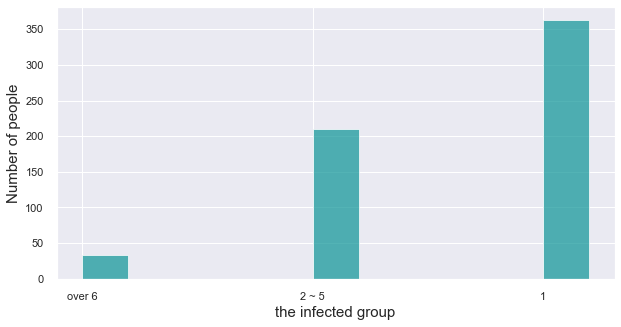

In [1102]:
# 그룹별 현황

label = ['over 6', '2 ~ 5', '1']

plt.figure(figsize=(10,5)) 
plt.bar(label, a, color='#0a9396', label='floating', alpha=0.7, width=0.2, align='edge')
plt.xlabel('the infected group', fontsize=15)
plt.ylabel('Number of people', fontsize=15)
plt.show()

### 전체 확진자의 연령 분포
확진자는 20대가 가장 많고 그 뒤로 50, 30, 40대 순서를 보이고 있다.
사회적 활동량이 많은 연령대에서 감염이 많이 이루어 진것으로 생각 할 수 있다.

<AxesSubplot:title={'center':'number of patients in infection_case values'}, xlabel='count', ylabel='age'>

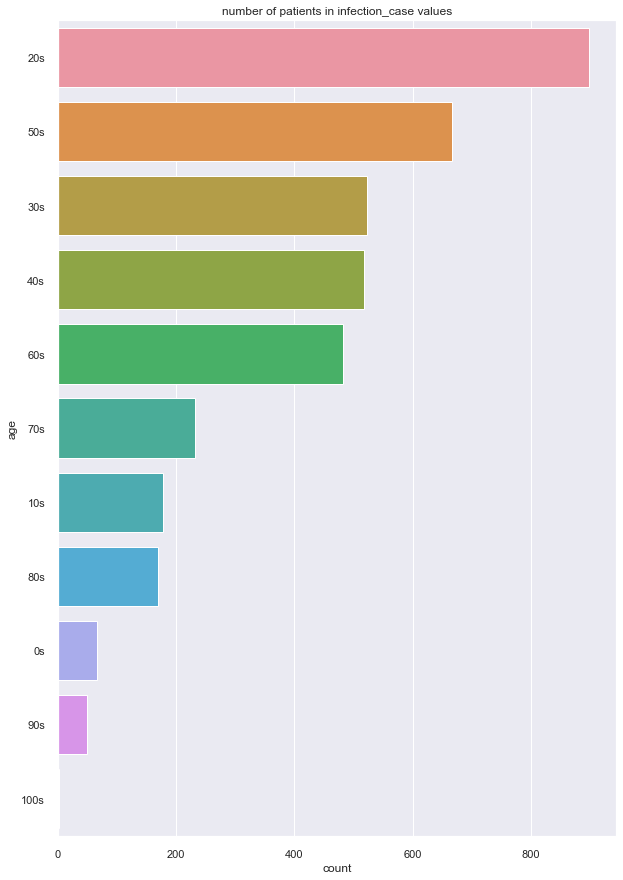

In [942]:
g = PI_df.groupby(['age'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

plt.figure(figsize = (10,15))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'age', x= 'count', data = g)

### 51 ~ 6명 감염시킨 확진자들의 연령 및 성별 분포

In [1115]:
# 각 그룹별 인구 통계학적 정보 추출 (그룹A)

data_sample_1 = pd.DataFrame(columns=PI_df.columns) # 데이터 프레임의 컬럼명을 추출해서 새로운 데이터 프레임을 만든다.

for id in id_over6:

    filtered_df_1 = PI_df[PI_df['patient_id'] == int(id)]
    data_sample_1 = data_sample_1.append(filtered_df_1)
    
data_sample_1.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2417,2000000205,female,70s,Korea,Gyeonggi-do,Seongnam-si,contact with patient,1000000138.0,8.0,NaN,2020.3.14,NaN,NaN,isolated
3546,4100000008,female,40s,Korea,Chungcheongnam-do,Cheonan-si,gym facility in Cheonan,NaN,130.0,2020.2.20,2020.2.26,2020.3.29,NaN,released
2379,2000000167,female,40s,Korea,Gyeonggi-do,Bucheon-si,contact with patient,1000000125.0,NaN,NaN,2020.3.10,NaN,NaN,isolated
1852,1400000209,female,NaN,Korea,Incheon,Bupyeong-gu,contact with patient,NaN,NaN,NaN,2020.5.31,NaN,NaN,isolated
2521,2000000309,female,80s,Korea,Gyeonggi-do,Gunpo-si,etc,NaN,NaN,2020.3.18,2020.3.19,NaN,NaN,isolated


### 연령별, 성별 분포

<AxesSubplot:xlabel='count', ylabel='sex'>

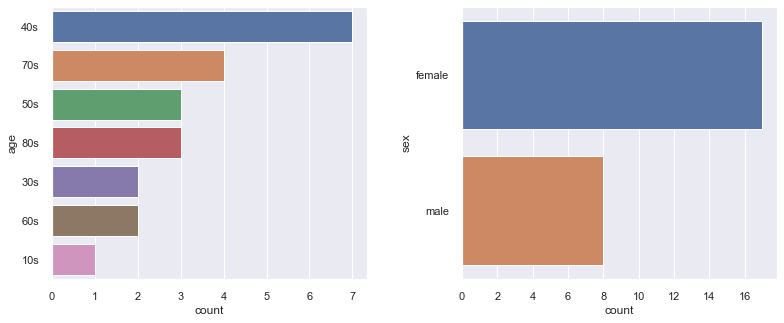

In [1165]:
# 연령 데이터
g = data_sample_1.groupby(['age'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

# 성별 데이터
g2 = data_sample_1.groupby(['sex'])['patient_id'].count()
g2 = g2.reset_index()
g2.rename(columns = {'patient_id':'count'}, inplace = True)
g2 = g2.sort_values('count', ascending = False)

fig = plt.figure(figsize = (13,5))
fig.subplots_adjust(wspace=0.3)
area01 = fig.add_subplot(1, 2, 1)
area02 = fig.add_subplot(1, 2, 2)

sns.barplot(y = 'age', x= 'count', data = g, ax=area01)
sns.barplot(y = 'sex', x= 'count', data = g2, ax=area02)

<AxesSubplot:xlabel='count', ylabel='province'>

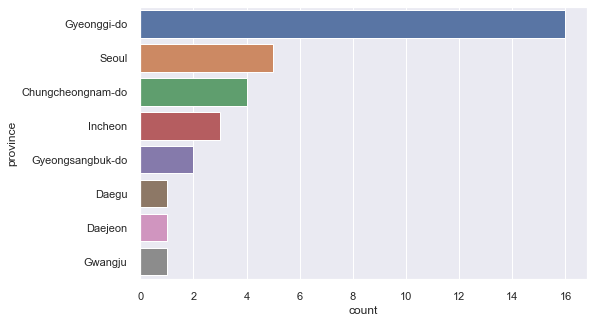

In [1215]:
g = data_sample_1.groupby(['province'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

fig = plt.figure(figsize = (8, 5))
sns.barplot(y = 'province', x= 'count', data = g)

### 2 ~ 5명 감염시킨 확진자들의 연령 및 성별 분포

In [1116]:
# 각 그룹별 인구 통계학적 정보 추출 (그룹B)

data_sample_2 = pd.DataFrame(columns=PI_df.columns) # 데이터 프레임의 컬럼명을 추출해서 새로운 데이터 프레임을 만든다.

for id in id_under5:

    filtered_df_2 = PI_df[PI_df['patient_id'] == int(id)]
    data_sample_2 = data_sample_2.append(filtered_df_2)
    
data_sample_2.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1831,1400000188,female,NaN,Korea,Incheon,Gyeyang-gu,NaN,NaN,NaN,NaN,2020.5.28,NaN,NaN,isolated
3494,4000000012,female,80s,Korea,Chungcheongbuk-do,Goesan-gun,etc,NaN,NaN,NaN,2020.3.4,2020.3.27,NaN,released
4657,6010000001,female,10s,Korea,Gyeongsangbuk-do,Seongju-gun,etc,NaN,NaN,2020.2.24,2020.2.26,NaN,NaN,released
2975,2000000763,female,30s,Korea,Gyeonggi-do,Bucheon-si,etc,NaN,NaN,2020.5.20,2020.5.24,NaN,NaN,isolated
2894,2000000682,male,30s,Korea,Gyeonggi-do,Yongin-si,Itaewon Clubs,NaN,NaN,2020.5.2,2020.5.6,NaN,NaN,isolated


### 연령별, 성별 분포

<AxesSubplot:xlabel='count', ylabel='sex'>

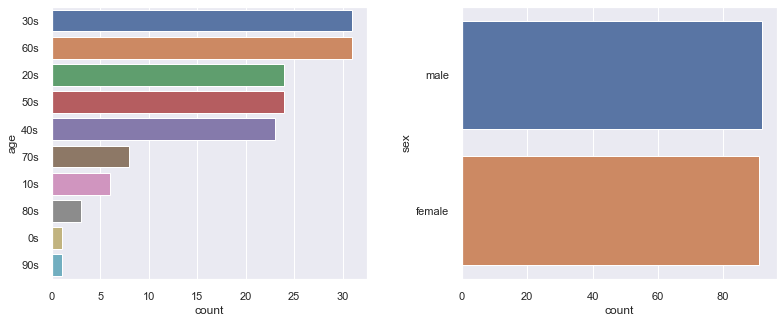

In [1166]:
g = data_sample_2.groupby(['age'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

# 성별 데이터
g2 = data_sample_2.groupby(['sex'])['patient_id'].count()
g2 = g2.reset_index()
g2.rename(columns = {'patient_id':'count'}, inplace = True)
g2 = g2.sort_values('count', ascending = False)

fig = plt.figure(figsize = (13,5))
fig.subplots_adjust(wspace=0.3)
area01 = fig.add_subplot(1, 2, 1)
area02 = fig.add_subplot(1, 2, 2)

sns.barplot(y = 'age', x= 'count', data = g, ax=area01)
sns.barplot(y = 'sex', x= 'count', data = g2, ax=area02)

<AxesSubplot:xlabel='count', ylabel='province'>

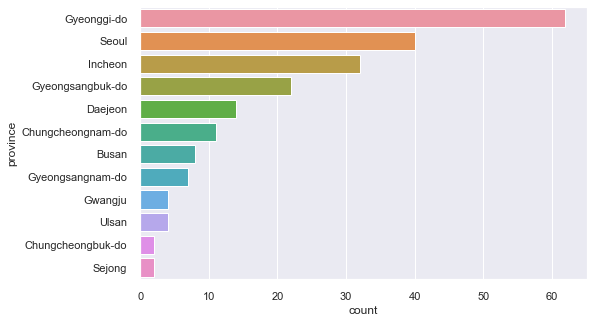

In [1214]:
g = data_sample_2.groupby(['province'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

fig = plt.figure(figsize = (8, 5))
sns.barplot(y = 'province', x= 'count', data = g)

### 1명만 감염시킨 확진자들의 연령 및 성별 분포

In [1130]:
# 각 그룹별 인구 통계학적 정보 추출 (그룹C)

data_sample_3 = pd.DataFrame(columns=PI_df.columns) # 데이터 프레임의 컬럼명을 추출해서 새로운 데이터 프레임을 만든다.

for id in id_infected1:

    filtered_df_3 = PI_df[PI_df['patient_id'] == int(float(id))]
    data_sample_3 = data_sample_3.append(filtered_df_3)
    
data_sample_3.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
3164,2000000952,NaN,NaN,Korea,Gyeonggi-do,Gwangmyeong-si,contact with patient,1000000991.0,NaN,NaN,2020.6.8,NaN,NaN,isolated
952,1000000953,NaN,NaN,Korea,Seoul,Yongsan-gu,Richway,NaN,NaN,NaN,2020.6.6,NaN,NaN,isolated
3196,2000000984,NaN,NaN,Korea,Gyeonggi-do,Gwangju-si,contact with patient,2000000959.0,NaN,NaN,2020.6.10,NaN,NaN,isolated
5015,6100000003,female,10s,Korea,Gyeongsangnam-do,Jinju-si,Shincheonji Church,NaN,NaN,NaN,2020.2.20,NaN,NaN,released
1046,1000001047,NaN,NaN,Korea,Seoul,etc,NaN,NaN,NaN,NaN,2020.6.10,NaN,NaN,released


### 연령별, 성별 분포

<AxesSubplot:xlabel='count', ylabel='sex'>

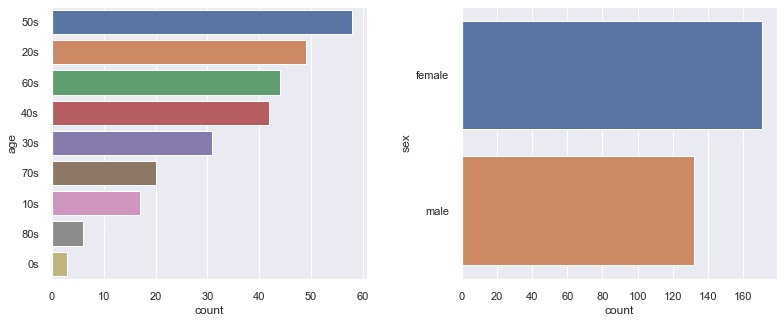

In [1167]:
g = data_sample_3.groupby(['age'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

# 성별 데이터
g2 = data_sample_3.groupby(['sex'])['patient_id'].count()
g2 = g2.reset_index()
g2.rename(columns = {'patient_id':'count'}, inplace = True)
g2 = g2.sort_values('count', ascending = False)

fig = plt.figure(figsize = (13,5))
fig.subplots_adjust(wspace=0.3)
area01 = fig.add_subplot(1, 2, 1)
area02 = fig.add_subplot(1, 2, 2)

sns.barplot(y = 'age', x= 'count', data = g, ax=area01)
sns.barplot(y = 'sex', x= 'count', data = g2, ax=area02)

### 상대를 많이 감염시킨 사람이 살고 있는 지역

<AxesSubplot:xlabel='count', ylabel='province'>

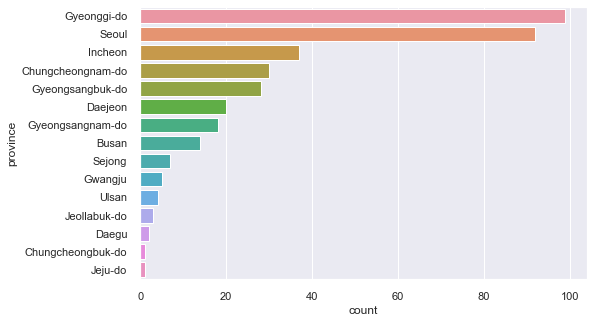

In [1216]:
g = data_sample_3.groupby(['province'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

fig = plt.figure(figsize = (8, 5))
sns.barplot(y = 'province', x= 'count', data = g)

In [1242]:
grouped = data_sample_3['patient_id'].groupby(data_sample_3['province'])
grouped.size()

province
Busan                14
Chungcheongbuk-do     1
Chungcheongnam-do    30
Daegu                 2
Daejeon              20
Gwangju               5
Gyeonggi-do          99
Gyeongsangbuk-do     28
Gyeongsangnam-do     18
Incheon              37
Jeju-do               1
Jeollabuk-do          3
Sejong                7
Seoul                92
Ulsan                 4
Name: patient_id, dtype: int64

<AxesSubplot:xlabel='count', ylabel='province'>

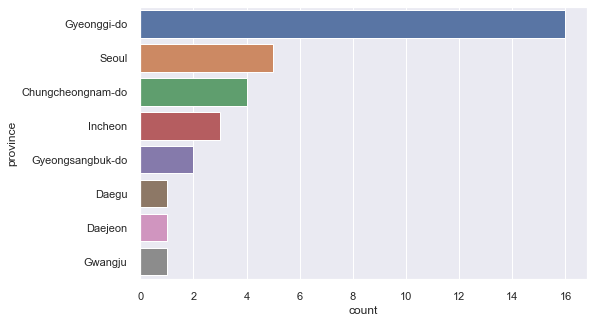

In [1247]:
#g = data_sample_3.groupby(['province'])['patient_id'].count()

g = data_sample_1['patient_id'].groupby(data_sample_1['province'])
g = g.size()

g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

fig = plt.figure(figsize = (8, 5))
sns.barplot(y = 'province', x= 'count', data = g)

### 접촉 정도

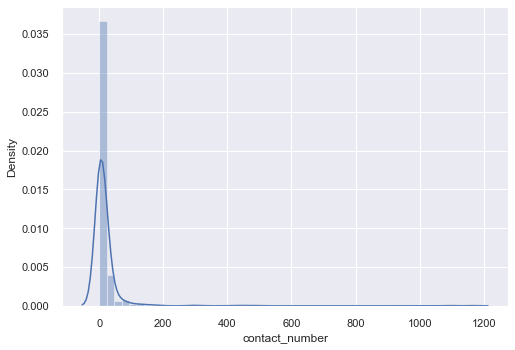

In [1075]:
sns.distplot(PI_df['contact_number'])
display()

In [1253]:
PI_df['contact_number'].describe()

count     784.000000
mean       17.325255
std        67.533881
min         0.000000
25%         2.000000
50%         4.000000
75%        14.000000
max      1160.000000
Name: contact_number, dtype: float64

In [1257]:
# 환자가 얼마나 많은 사람과 접촉하였는지 분석하였다

contact_case = PI_df['contact_number'].value_counts()
print(contact_case)

3.0     96
2.0     92
1.0     87
0.0     83
4.0     51
        ..
47.0     1
46.0     1
64.0     1
66.0     1
72.0     1
Name: contact_number, Length: 84, dtype: int64


In [ ]:
grouped = PI_df['patient_id'].groupby(data_sample_3['province'])
grouped.size()

In [1255]:
contact_case.max()

1160.0

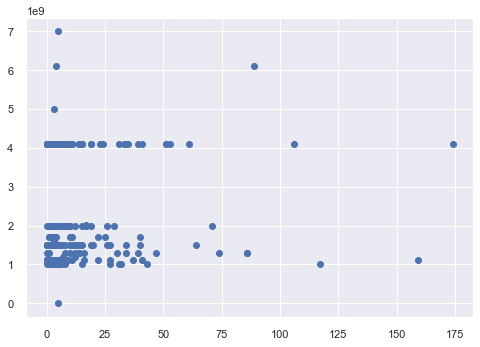

In [1259]:
plt.scatter(PI_df['contact_number'],PI_df['infected_by'])
plt.show()

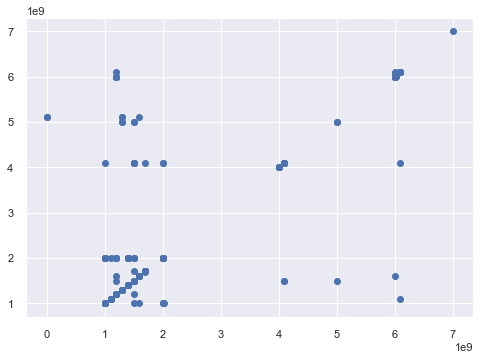

In [1262]:
plt.scatter(PI_df['infected_by'],PI_df['contact_number'])
plt.show()

### 연령대별 이동량
연령대별 이동량을 보면 20, 30, 40, 50대가 높은 수준을 보이며 50대 이후부터 확연하 저하 된 것을 확인 할 수 있다.

In [1210]:
birth = SF_df.groupby(by = 'birth_year').fp_num.agg('sum')
birth.head()

birth_year
20    5441769700
30    6069018790
40    6054699830
50    5675739830
60    3706127050
Name: fp_num, dtype: int64

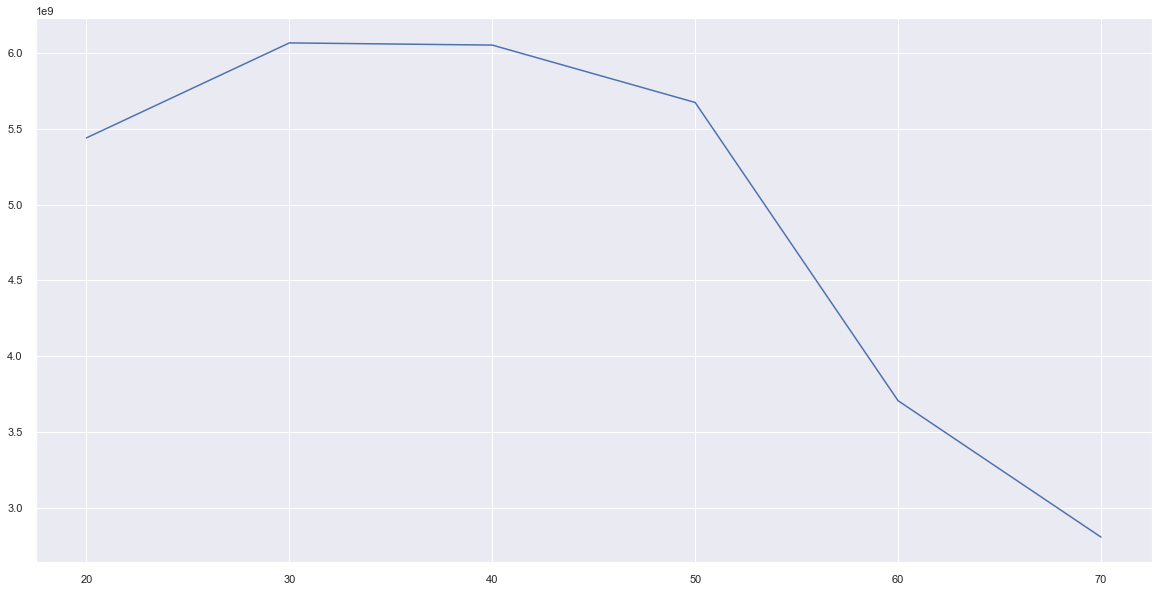

In [1211]:
plt.figure(figsize=(20,10)) 
plt.plot(birth)
plt.show()

### 감염경로(infection case)에 대한 분석
감염경로는 확진자와의 직접접촉이 가장 많은 것으로 확인된다.  
나머지 또한 특정 장소에서의 집단감염으로 인한 것이 원인이다.
경로를 알수 없는 감염도 매우 많이 존재 했던 것으로 확인된다.  
나머지 케이스 들은 특정 장소에서의 감염으로 볼 수 있으며 이들은 집단감염과 그렇지 않은 감염으로 구분 할 수 있다.

In [13]:
# 감염경로의 총 개수는 52개로 분류된다.

print('감염경로의 총 개수: ',len(PI_df['infection_case'].unique()))

감염경로의 총 개수:  52


In [14]:
# 감염경로의 결측치 확인, 919개의 결측치가 확인된다.
# 해당 결측치는 감염 경로를 알 수 없는 것으로 파악해야 한다.

PI_df['infection_case'].isnull().sum()

919

<AxesSubplot:title={'center':'number of patients in infection_case values'}, xlabel='count', ylabel='infection_case'>

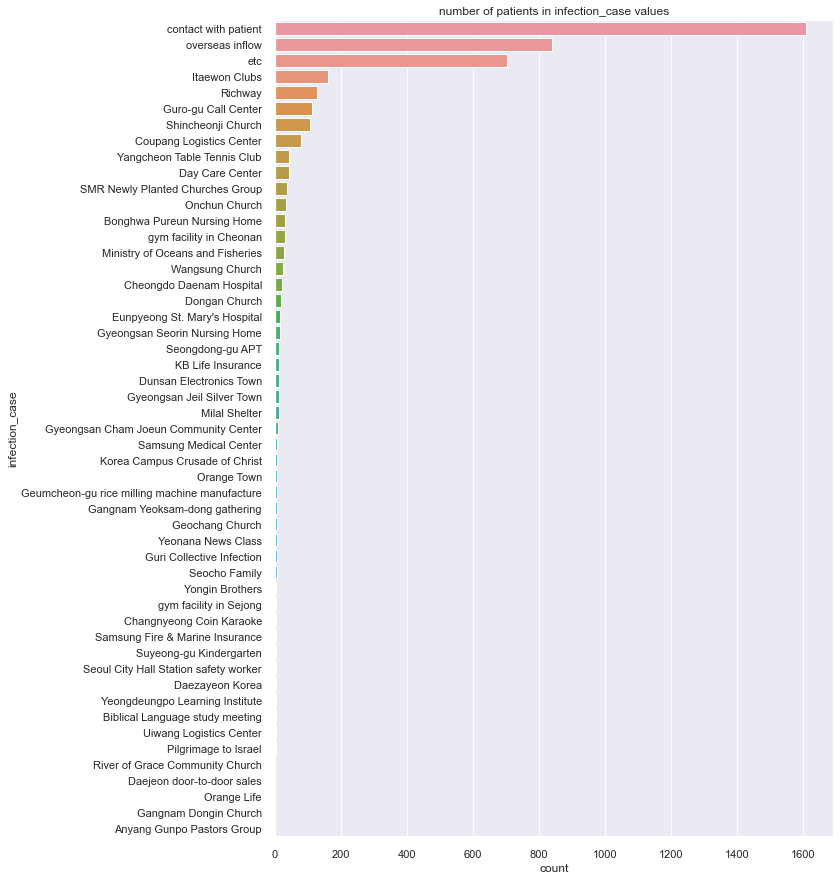

In [949]:
# 장소별 확진자 발생수 시각화

g = PI_df.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

plt.figure(figsize = (10,15))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'infection_case', x= 'count', data = g)
#display()

In [1174]:
# 필요한 column 추출한다.

C_df_modi = C_df[['city','infection_case', 'confirmed', 'latitude', 'longitude']]
display(C_df_modi.head())

,city,infection_case,confirmed,latitude,longitude
0,Yongsan-gu,Itaewon Clubs,139,37.538621,126.992652
1,Gwanak-gu,Richway,119,37.48208,126.901384
2,Guro-gu,Guro-gu Call Center,95,37.508163,126.884387
3,Yangcheon-gu,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,Dobong-gu,Day Care Center,43,37.679422,127.044374


In [1197]:
m = folium.Map([36.4, 128], zoom_start=7)
fg = folium.FeatureGroup(name='My Map')

for index, row in C_df_modi.iterrows():
    if row[3] and row[4] == '-':
        pass
        #print(row[4])
    else:        
        folium.CircleMarker(
            location = [row[3],row[4]],
            fill_color='#ff3399',
            color = '#E91E63',
            radius = row['confirmed']*0.03,
            popup=int(row['confirmed'])
        ).add_to(m)
m

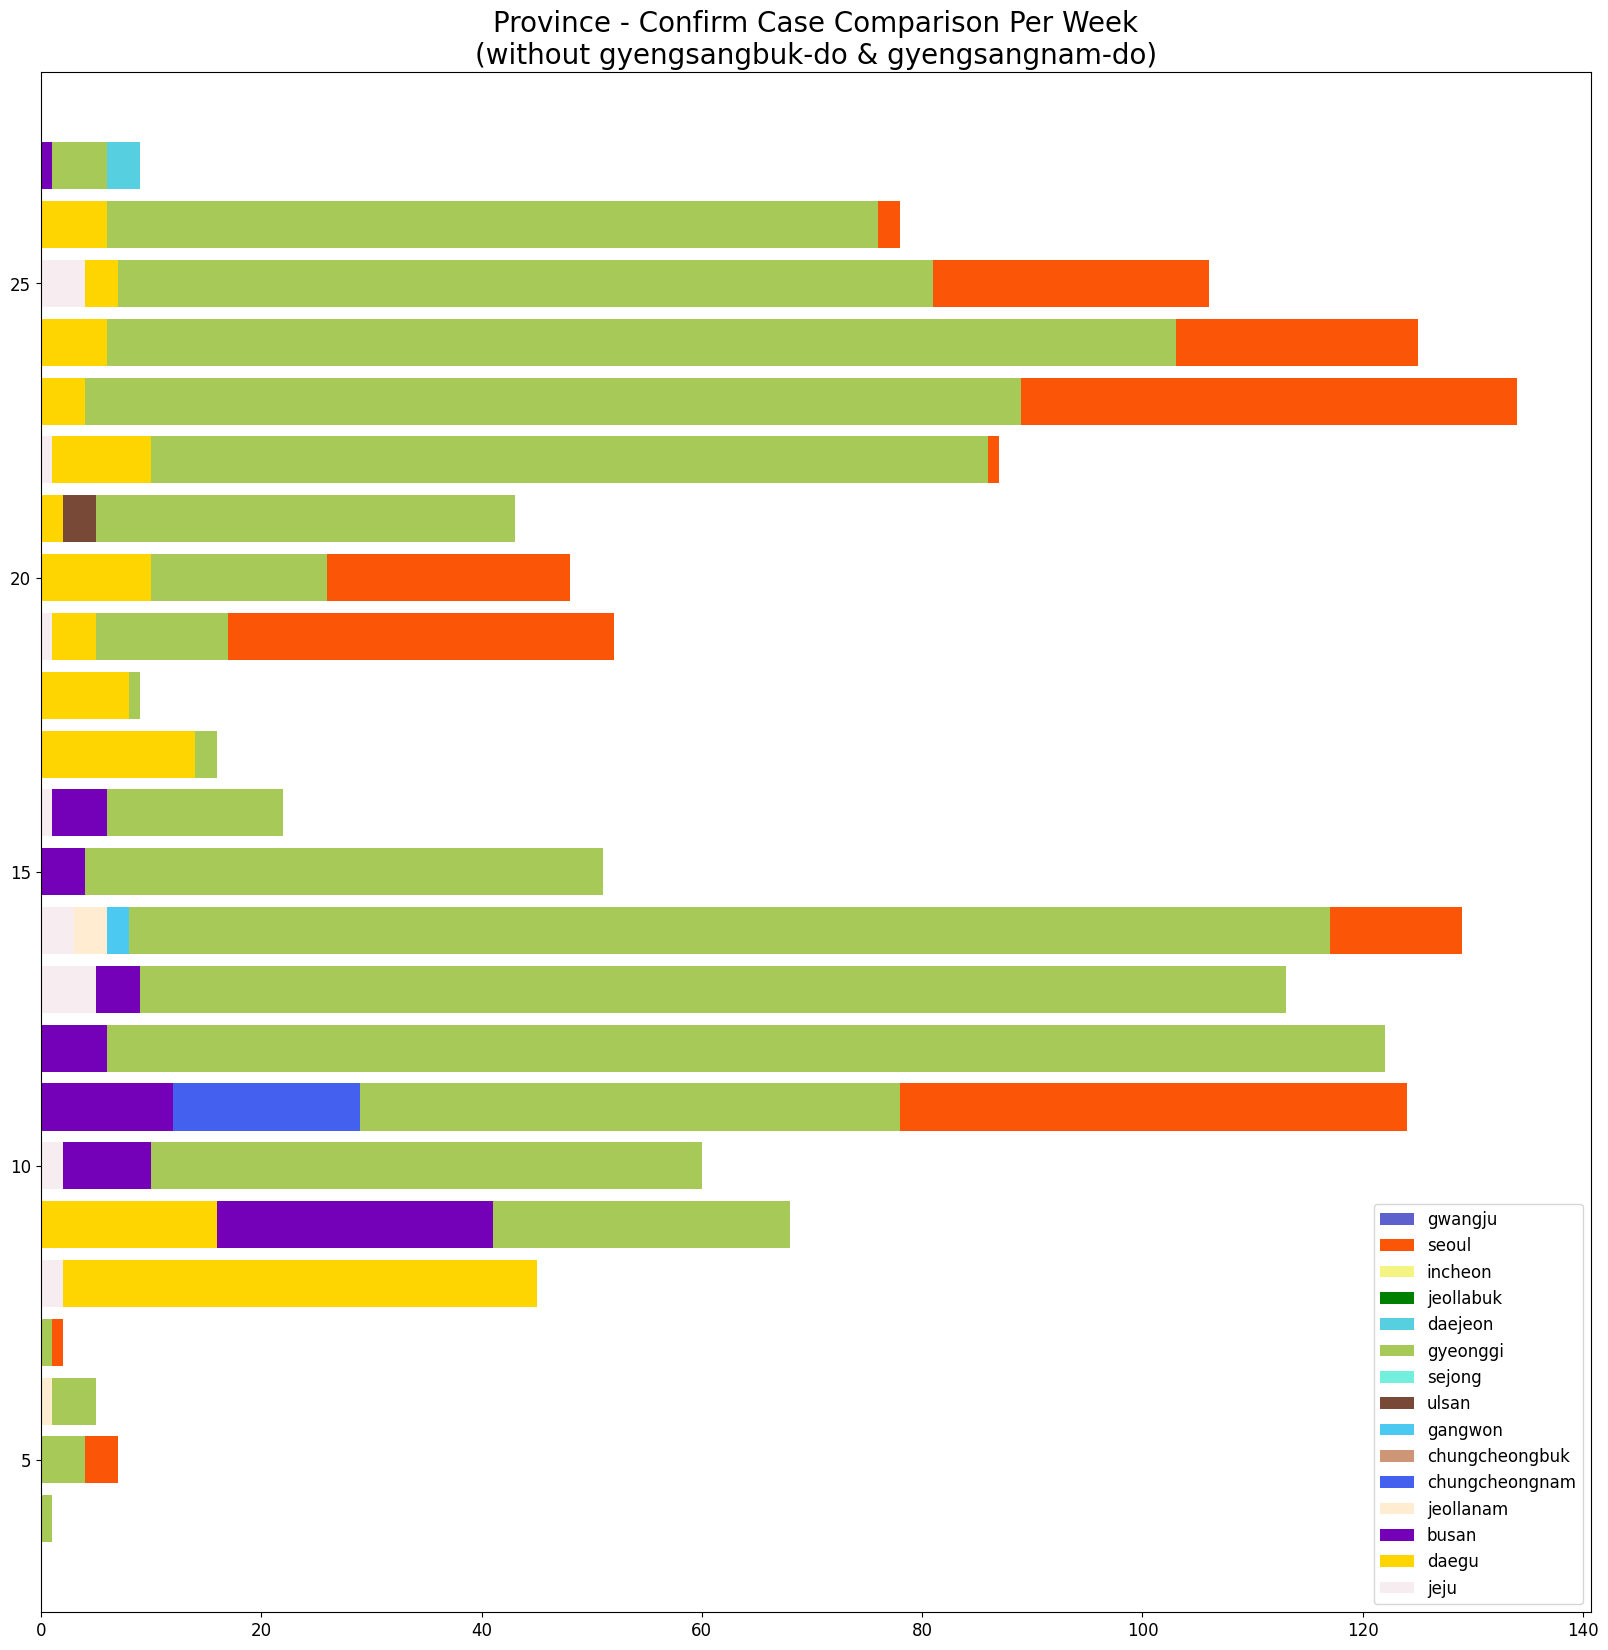

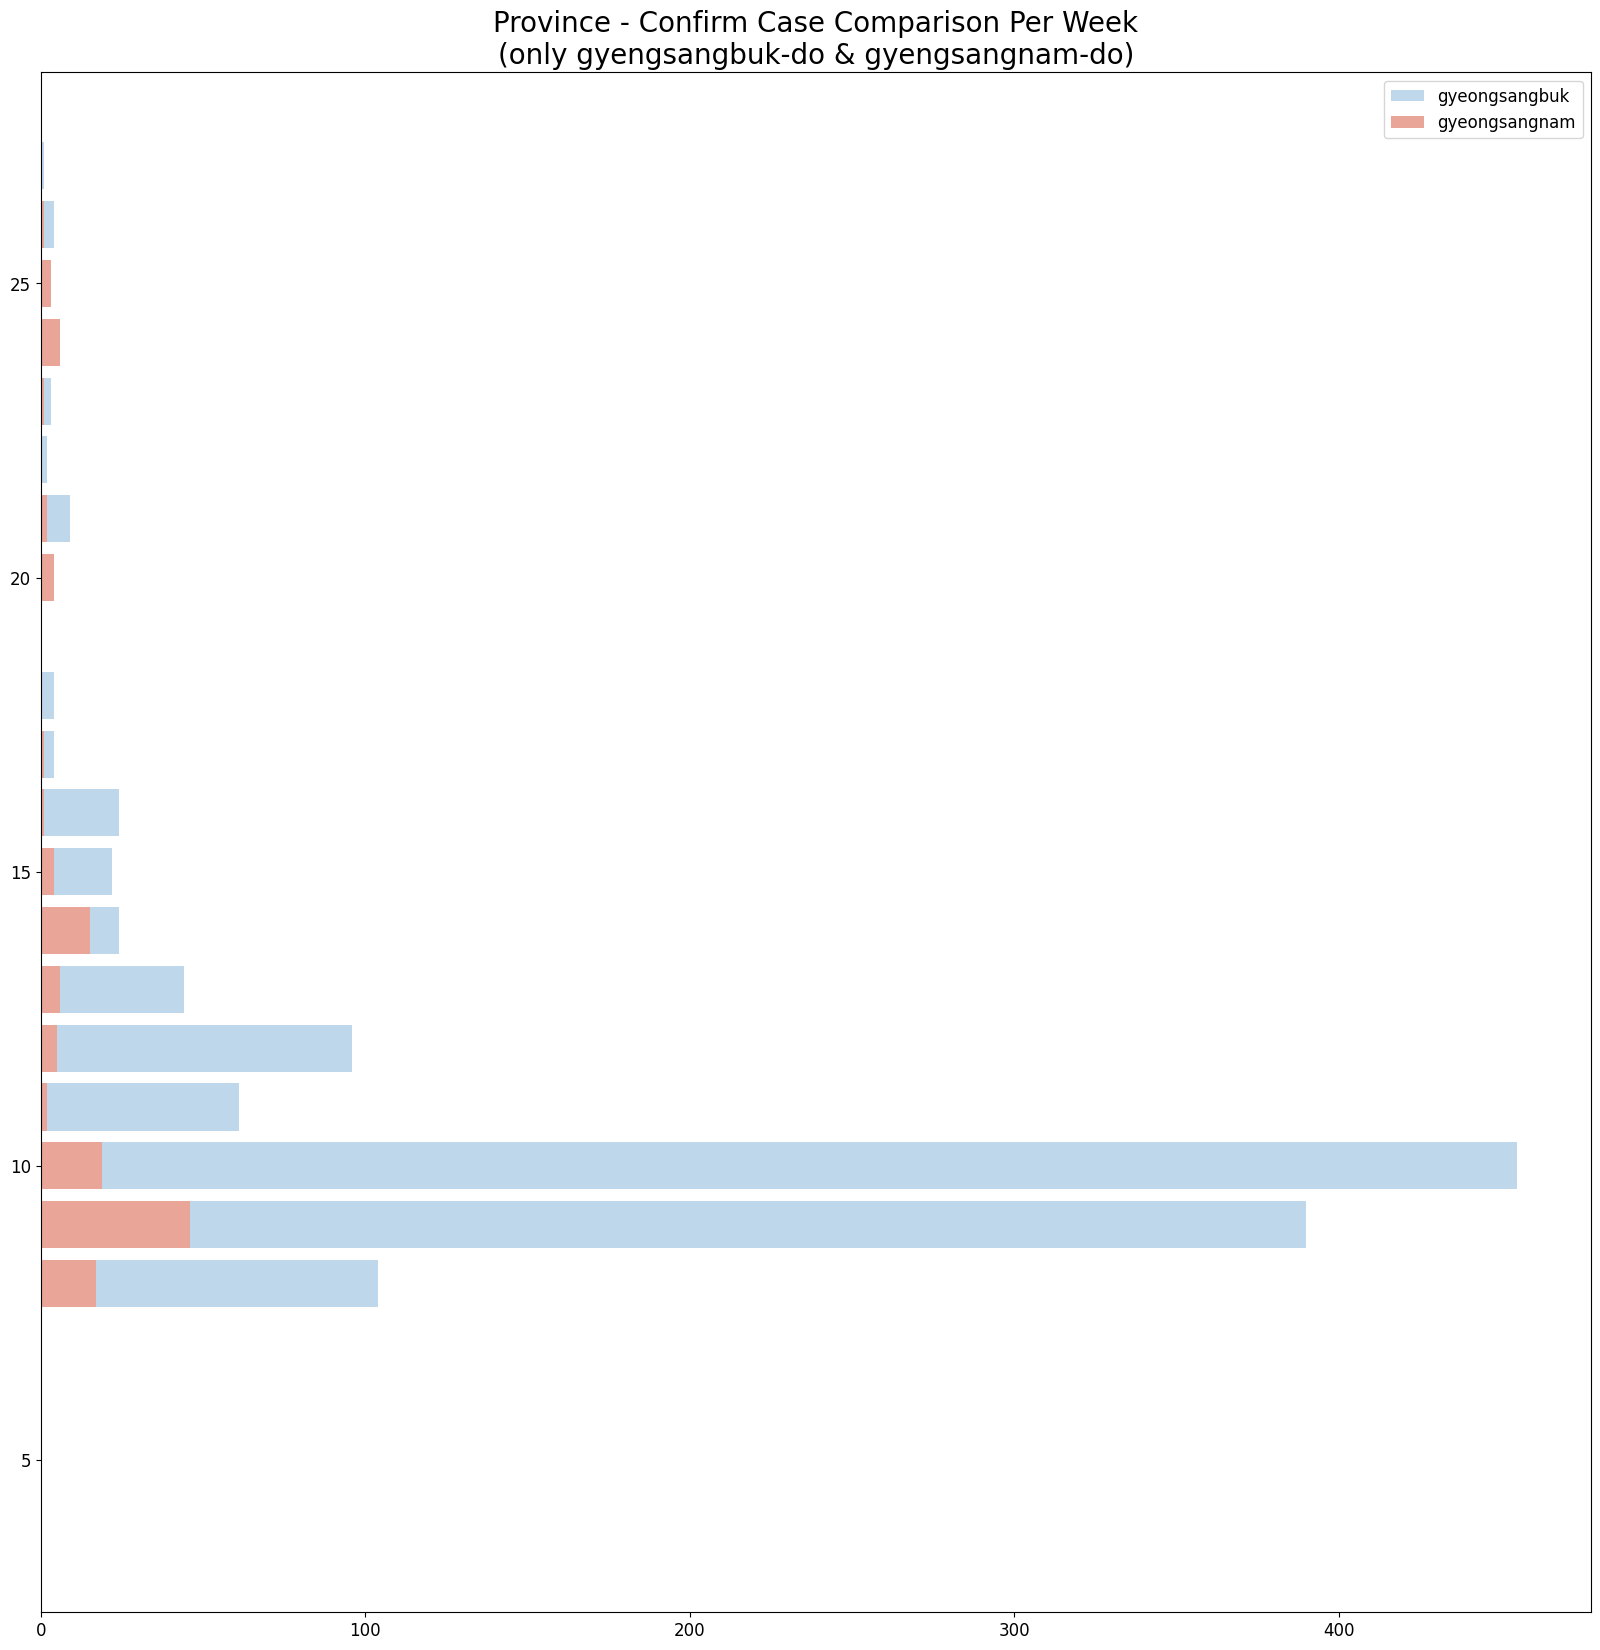

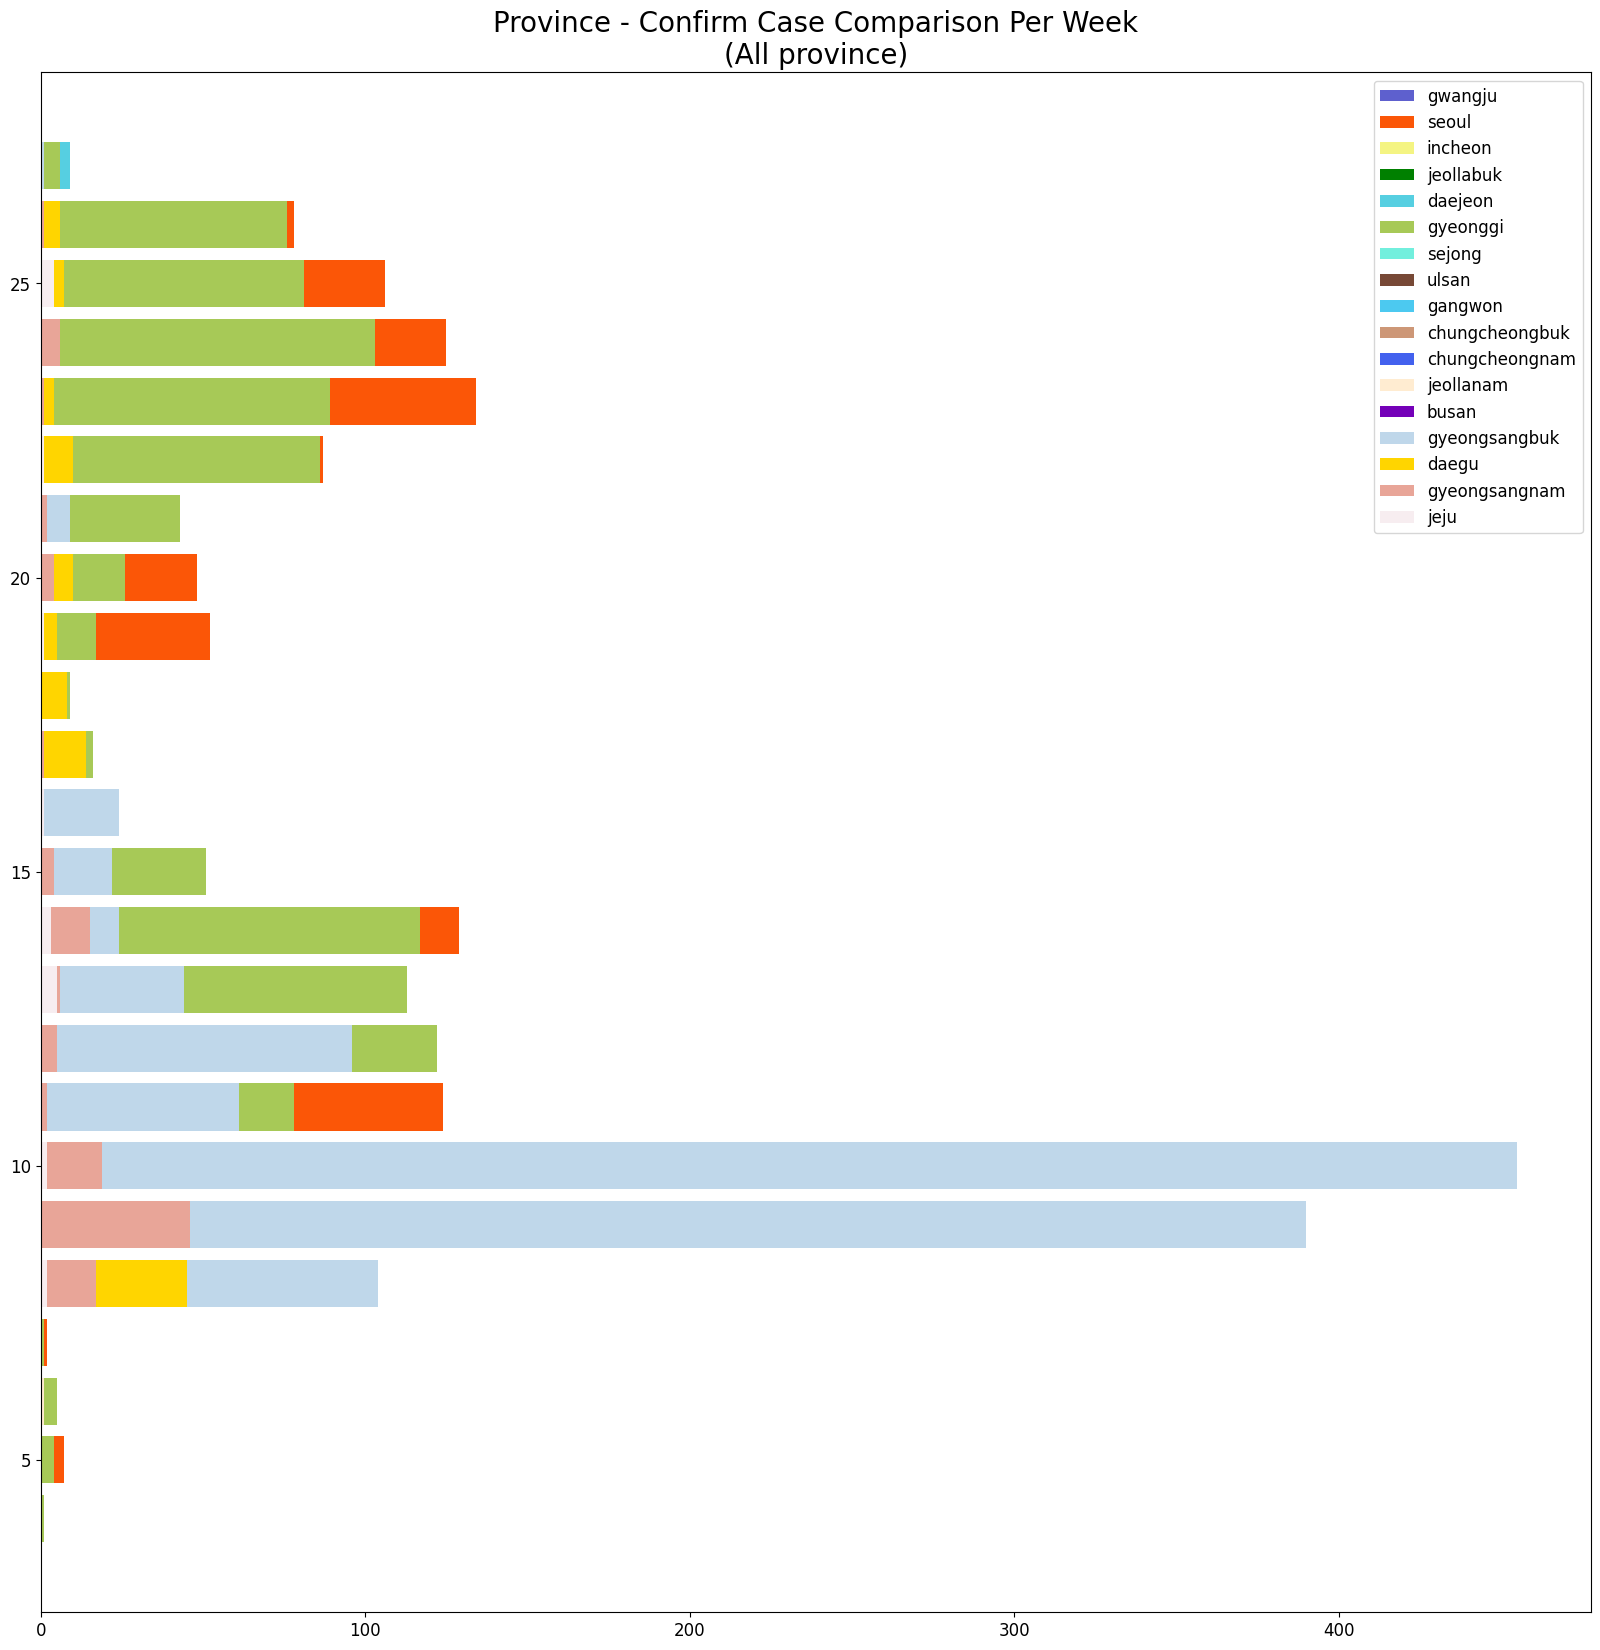

### 연령대별 이동량 (승민)

## 일자별 코로나 확진현황
Time.csv의 데이터를 사용해서 대한민국의 일별 코로나 확진현황을 살펴 보자.

In [1206]:
def make_daily(df):
    daily = df.sort_values(['date'], ascending = False)
    daily = daily.reset_index()
    daily = daily.drop(['index'],axis=1)
    
    only_case = []

    for i in range(len(daily)-1):
        only_case.append(daily['confirmed'][i]-daily['confirmed'][i+1])
    only_case.append(1)

    daily['daily'] = only_case

    daily = daily.sort_values(['date'],ascending=True)
    daily = daily.reset_index()
    daily = daily.drop(['index'],axis=1)
    
    return daily

In [1207]:
# time data - date:날짜, confirmed:누적 확진자수 
time = pd.read_csv('./data/covid19/Time.csv', usecols= ['date', 'confirmed']) 
time = make_daily(time)

In [1209]:
# 그래프 

fig = go.Figure()
fig.add_trace(go.Line(x=time['date'], y = time['confirmed'], name = "일자별 누적 확진자 수(전국)", marker_color='#009770', yaxis="y"))
fig.add_trace(go.Bar(x=time['date'], y = time['daily'], name = "일자별 확진자 수(전국)", marker_color='#E91E63', yaxis="y2"))
fig.update_layout(shapes=[dict(fillcolor="rgba(211, 211, 211, 0.3)",line={"width": 0}, type="rect",x0="2020-02-25",x1="2020-03-09",xref="x",y0=0,y1=0.95,yref="paper")])
fig.update_layout(xaxis=dict(rangeslider=dict(autorange=True, range=["2020-01-20", "2020-06-30"],visible=True),type="date"),
                  yaxis=dict(anchor="x",autorange=True,domain=[0, 0.5],linecolor="#009770",mirror=True,range=[-60.0858369099, 28.4406294707],showline=True,side="right",
                             tickfont={"color": "#009770"},tickmode="auto",ticks="",titlefont={"color": "#009770"},type="linear",zeroline=False),
                  yaxis2=dict(anchor="x",autorange=True,domain=[0.5, 0.95],linecolor="#E91E63",mirror=True,range=[29.3787777032, 100.621222297],showline=True,side="right",
                             tickfont={"color": "#E91E63"},tickmode="auto",ticks="",titlefont={"color": "#E91E63"},type="linear",zeroline=False))
fig.update_layout(dragmode="zoom", hovermode="x", height=700, template="plotly_dark", title_text = "일자별 코로나 확진 현황", margin=dict(t=100, b=100))
fig.show()

## 3. Policy.csv
한국의 COVID-19에 대한 정부 정책 데이터

In [20]:
display(Pol_df.head())

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [36]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = Pol_df['start_date'].min(), Pol_df['start_date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-03
가장 최근의 날짜:  2020-06-10


## 4. Region.csv

In [22]:
R_df.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


## 5. SearchTrend.csv

In [23]:
ST_df.head()

,date,cold,flu,pneumonia,coronavirus
0,2016-01-01,0.11663,0.05590,0.15726,0.00736
1,2016-01-02,0.13372,0.17135,0.20826,0.00890
2,2016-01-03,0.14917,0.22317,0.19326,0.00845
3,2016-01-04,0.17463,0.18626,0.29008,0.01145
4,2016-01-05,0.17226,0.15072,0.24562,0.01381


In [35]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = ST_df['date'].min(), ST_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2016-01-01
가장 최근의 날짜:  2020-06-29


## 6. SeoulFloating
국내 최대 포털사이트 네이버에서 검색된 키워드의 트렌드 데이터

In [26]:
SF_df.head()

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880


In [34]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = SF_df['date'].min(), SF_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-01
가장 최근의 날짜:  2020-05-31


## 7. Time.csv
한국의 COVID-19 상황에 대한 시계열 데이터(테스트, 음성, 양성, 해제, 누적 사망자)

In [30]:
T_df.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [33]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = T_df['date'].min(), T_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-20
가장 최근의 날짜:  2020-06-30


## 8. TimeAge.csv
한국의 연령별 코로나19 현황 시계열 데이터

In [39]:
TA_df.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


In [41]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = TA_df['date'].min(), TA_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-03-02
가장 최근의 날짜:  2020-06-30


## 9. TimeGender.csv
한국의 성별별 코로나19 현황 시계열 데이터

In [43]:
TG_df.head()

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20


In [45]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = TG_df['date'].min(), TG_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-03-02
가장 최근의 날짜:  2020-06-30


## 10. TimeProvince.csv
한국의 지역별 코로나19 현황 시계열 데이터

In [47]:
TP_df.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


In [49]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = TP_df['date'].min(), TP_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-20
가장 최근의 날짜:  2020-06-30


## 11. Weather.csv
한국 지역의 날씨 데이터

In [51]:
W_df.head()

,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,10000,Seoul,2016-01-01,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
1,11000,Busan,2016-01-01,5.3,1.1,10.9,0.0,7.4,340.0,52.1
2,12000,Daegu,2016-01-01,1.7,-4.0,8.0,0.0,3.7,270.0,70.5
3,13000,Gwangju,2016-01-01,3.2,-1.5,8.1,0.0,2.7,230.0,73.1
4,14000,Incheon,2016-01-01,3.1,-0.4,5.7,0.0,5.3,180.0,83.9


In [52]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = T_df['date'].min(), T_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-20
가장 최근의 날짜:  2020-06-30
